Elevation changes from SAR Amplitude images
==============

This notebook shows how to get elevation changes from SAR amplitude images using shape from shading techniques explained in (cite article). In this notebook we show the results for a Shishaldin dataset using TerraSAR-X images and an ArticDEM. Unfortunately the notebook cannot be rerun because it needs the original slc files and DEM that are not open source. 

## Importing libraries

'sfs' coregisters the slc images with a DEM

In [1]:
%matplotlib inline
from mosart import sfs
from mosart import lsquares
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from functools import partial
import matplotlib.image as image
import datetime as dt
import matplotlib.style
import matplotlib as mpl
import datetime as dt
mpl.rcParams.update(mpl.rcParamsDefault)

## H5 file names

The variable 'cor_stack' will contain the name of the h5 file where all the coregistered images and DEM will be. The variable 'pre_stack' will contain the name of the h5 file that will have the area of interest and the gradient of the given DEM.

In [2]:
cor_stack='projections.h5'
pre_stack='ascending.h5'

## Coregistration of slcs

In the next cell we have the rutine that coregisters all slcs images contain in the folder 'data/slcs'. The output filename will be given by cor_stack. 

**THIS RUTINE USES ISCE FOR COREGISTRATION**.

In [3]:
#Coregistering SAR images with the earliest image

#sfs.coregistration_bursts('burst_list.txt')

### Plotting coregistered image and AOI

'sfs' helps to get the area of interest in radar coordinates using a lon/lat box. 

<IPython.core.display.Javascript object>


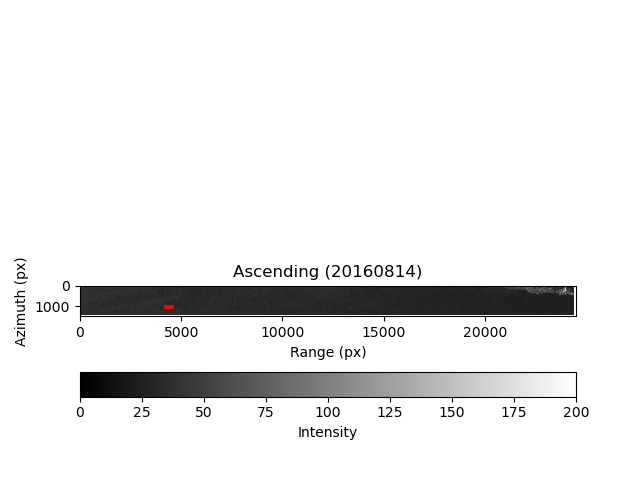

In [4]:
%matplotlib notebook
#Reading h5 file with coregistered images
h5i=h5py.File(cor_stack,'r')
keys=[key for key in h5i.keys() if key.isdigit()]
lonrdr=h5i['lon'][:]
latrdr=h5i['lat'][:]
amps=h5i[keys[11]][:]
h5i.close()

#Getting AOI in radar coordinates corresponding to certain longitudes and latitudes
xs=[4200,4600]
ys=[990,1100]
x0=xs[0]
y0=ys[0]
xsizet=xs[-1]-xs[0]
ysizet=ys[-1]-ys[0]
#x0,y0,xsizet,ysizet=sfs.get_box2(lonrdr,latrdr,lons=lons,lats=lats)

#Plotting a coregistered image and the AOI
plt.figure()
plt.title('Ascending ('+keys[1]+')')
plt.imshow(amps,cmap='gray',vmin=0,vmax=200)
plt.colorbar(label='Intensity',orientation='horizontal')
#plt.quiver(1000,4000,0,-1500,units='x',color='magenta',scale=1)
#plt.plot([1000,1500],[4000,4000],color='magenta')
plt.plot([x0,x0,x0+xsizet,x0+xsizet,x0],[y0,y0+ysizet,y0+ysizet,y0,y0],color='red',label='AOI')
#plt.text(1200,3800,'look',color='magenta')
#plt.text(100,5000,'flight',color='magenta')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')
#plt.legend()

plt.show()

### Plots for AOI

Here we plot the area of interest around the Shishaldin crater and the gradient of the ArcticDEM.

<IPython.core.display.Javascript object>


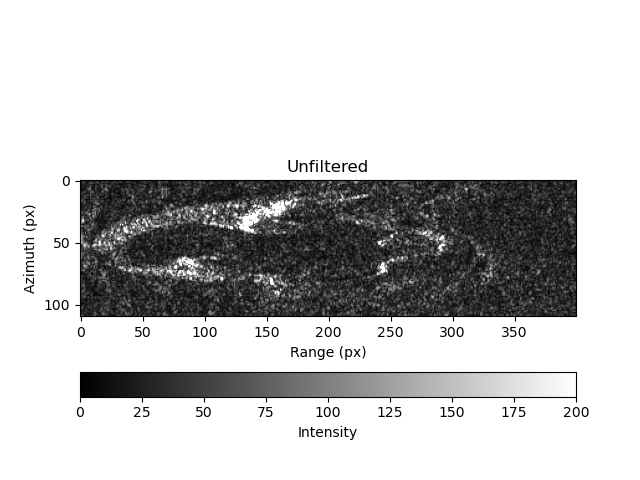

<IPython.core.display.Javascript object>


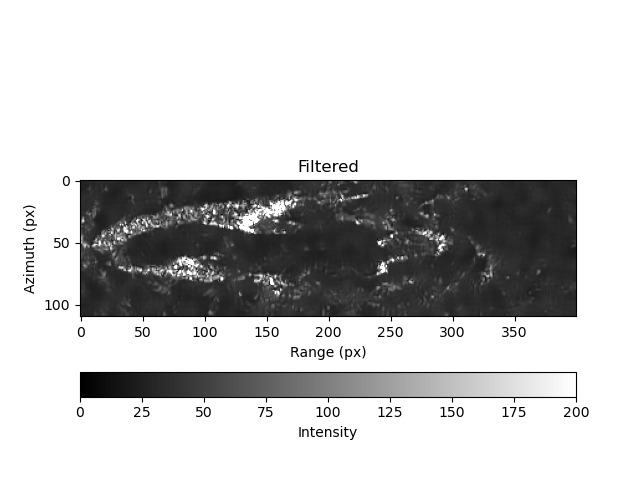

In [5]:
from skimage.restoration import denoise_nl_means

amps_clip=amps[ys[0]:ys[1],xs[0]:xs[1]]

sigma_amp=20
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=5,  # 13x13 search area
                )
famps=denoise_nl_means(amps_clip, h=0.6 * sigma_amp, sigma=sigma_amp, fast_mode=True, **patch_kw)

plt.figure()
plt.title('Unfiltered')
plt.imshow(amps_clip,cmap='gray',vmin=0,vmax=200)
plt.colorbar(label='Intensity',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.figure()
plt.title('Filtered')
plt.imshow(famps,cmap='gray',vmin=0,vmax=200)
plt.colorbar(label='Intensity',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')
plt.show()

## Preprocessing

The 'preprocessing' function clip the AOI and calculates the gradient of the given DEM along range coordinates 

In [6]:
#Creating new h5file clipping the AOI and calculating DEM gradient
sfs.preprocessing(xs=xs,ys=ys,projections=cor_stack,path='A',sigma_amp=sigma_amp,patch_kw=patch_kw)

Preprocessing for  20160721
Preprocessing for  20160814
Preprocessing for  20160907
Preprocessing for  20161007
Preprocessing for  20161031
Preprocessing for  20161124
Preprocessing for  20161218
Preprocessing for  20170111
Preprocessing for  20170204
Preprocessing for  20170312
Preprocessing for  20170405
Preprocessing for  20170417
Preprocessing for  20170429
Preprocessing for  20170511
Preprocessing for  20170523


## Making Weight matrix

This cell creates the weight matrix for the inversion

<IPython.core.display.Javascript object>


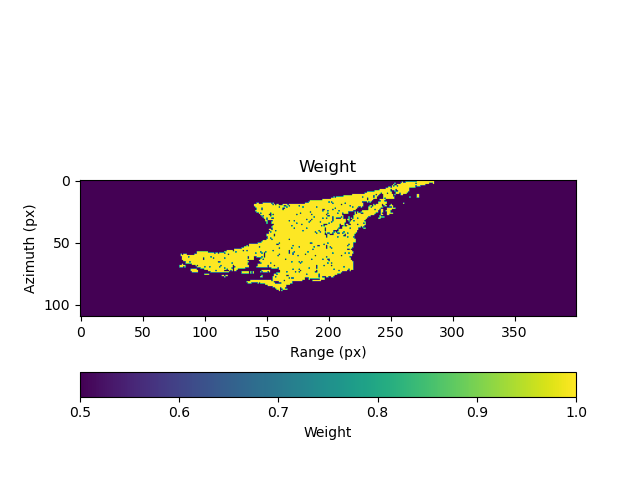

In [14]:
%matplotlib notebook
#Reading amplitude image for the AOI
h5i=h5py.File(pre_stack,'r')
keys=[key for key in h5i.keys() if key.isdigit()]
amp=h5i[keys[0]][:]
grd=h5i['grad'][:]
dem=h5i['dem'][:]
tamps=np.array([h5i[key][:] for key in keys])
h5i.close()

weights=np.ones(tamps.shape)*0.5
waters=np.full(tamps.shape, True)
tgrddefs=[]
for i,amps in enumerate(tamps):
    water=amps[:,350::]
    cond=np.logical_and(np.percentile(water,10)<amps,amps<np.percentile(water,90))
    cond1=dem>13.2
    waters[i,:,:]=cond

    condd=np.logical_and(np.logical_not(cond),cond1)
    weights[i,:,:][condd]=1
    
plt.figure()
plt.title('Weight')
plt.imshow(weights[0,:,:])
plt.colorbar(orientation='horizontal',label='Weight')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')
plt.show()

## Reconstruction of DEMs

The next cells shows the process to construct a DEM per amplitude image

### Standard deviation on amplitude images

We need to calculate the standar deviation on the amplitude images through time, to assign weights when the inversion is made

### Construction of DEMs

The library 'lsquares' makes the inversions using a least squares approach. Here we paralellize to optimize the calculation time.

In [15]:
#Calculate standard deviation on the amplitude images
#sfs.calc_std(pre_stack)

#Construction of DEMs
demdefs=[]
def onedem(i,keys,weights,waters):
    key=keys[i]
    weight=weights[i,:,:]
    water=waters[i,:,:]
    #water=None
    demdef,grddef,weights=lsquares.getdem(key,h5file='ascending.h5',weight=weight,water=water)
    return demdef,grddef,'d'
pool = multiprocessing.Pool(processes=13)
subrutina=partial(onedem,keys=keys,weights=weights,waters=waters)
demdefs,grddefs,nada=zip(*pool.map(subrutina, range(len(keys))))
pool.close()
pool.join()

Start DEM for 20160721


/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Start DEM for 20160814


/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Finished DEM for Start DEM for20160721 
20160907
Start DEM for 

/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


20161007


/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Finished DEM for 20160814
Start DEM for 20161031


/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Finished DEM forStart DEM for 20160907 20161124

Finished DEM for 20161007
Start DEM for 20161218

/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Start DEM forFinished DEM for  2017011120161031

Finished DEM for 

/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


20161124


/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Start DEM for 20170204
Finished DEM for 20161218Start DEM for
 20170312


/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Finished DEM for 20170111
Finished DEM for 20170204
Finished DEM for 20170312
Start DEM forStart DEM for 

/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


 2017042920170405



/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Start DEM for 20170511


/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mario/miniforge3/envs/mosart/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Start DEM forStart DEM for  2017041720170523

Finished DEM for 20170429
Finished DEM for 20170405
Finished DEM for 20170523Finished DEM for
 20170511
Finished DEM for 20170417


### Plot of ArticDEM and reconstructed DEM

Here we show the original ArticDEM and a reconstructed DEM using the amplitude image on November 3, 2019

<IPython.core.display.Javascript object>


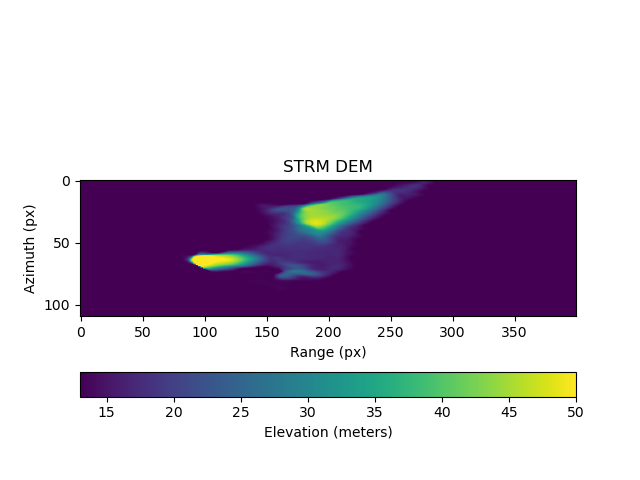

<IPython.core.display.Javascript object>


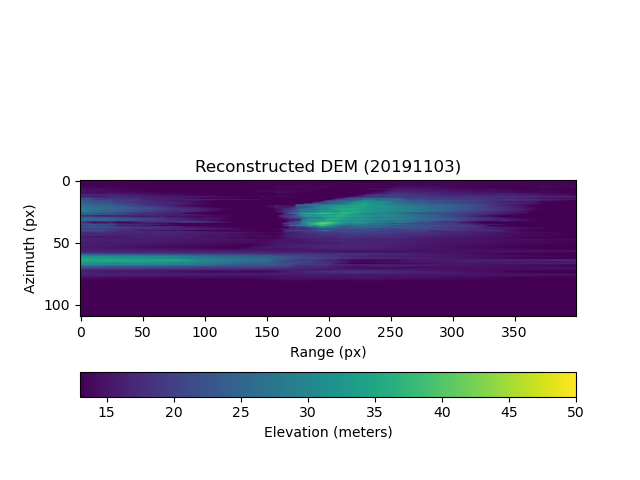

In [19]:
#Plot one uncorrected DEM
plt.figure()
plt.title('STRM DEM')
plt.imshow(dem,vmin=13,vmax=50)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.figure()
plt.title('Reconstructed DEM (20191103)')
plt.imshow(demdefs[1],vmin=13,vmax=50)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.show()

<IPython.core.display.Javascript object>


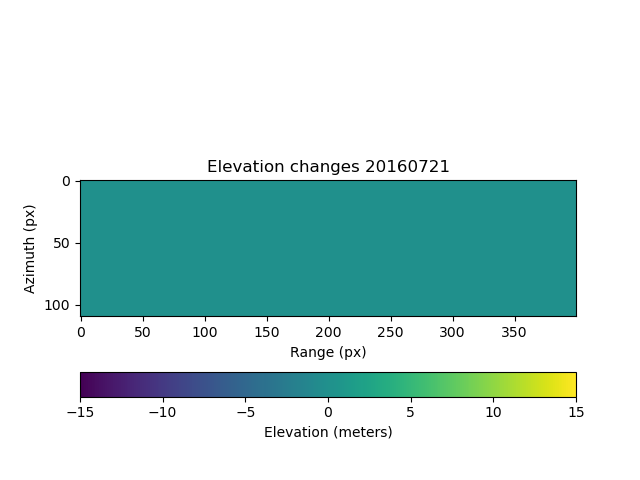

<IPython.core.display.Javascript object>


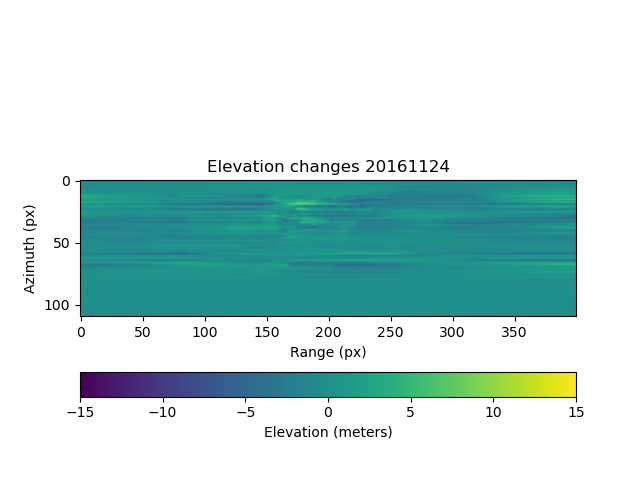

<IPython.core.display.Javascript object>


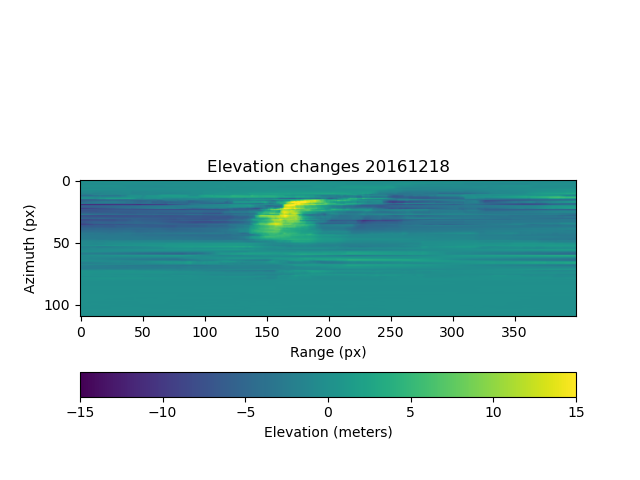

<IPython.core.display.Javascript object>


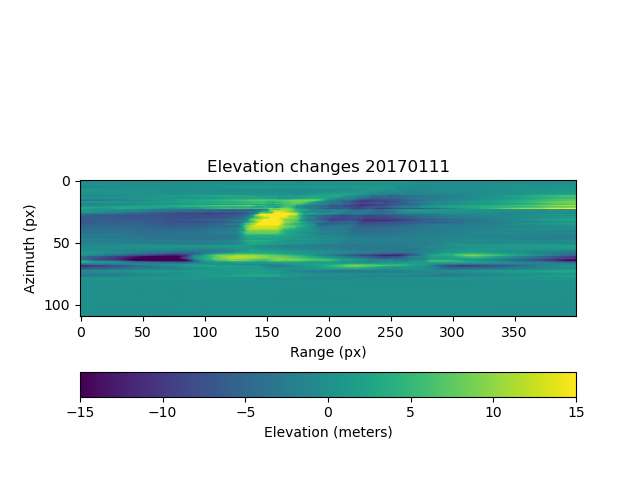

<IPython.core.display.Javascript object>


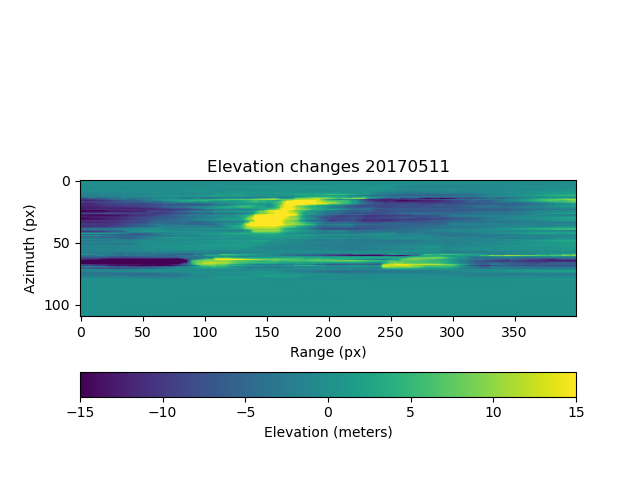

In [22]:
reference=0

changes=[]
for demdef in demdefs:
    changes.append(demdef-demdefs[reference])
changes=np.array(changes)

index=0
plt.figure()
plt.title('Elevation changes '+keys[index])
plt.imshow(changes[index],vmin=-15,vmax=15)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

index=5
plt.figure()
plt.title('Elevation changes '+keys[index])
plt.imshow(changes[index],vmin=-15,vmax=15)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

index=6
plt.figure()
plt.title('Elevation changes '+keys[index])
plt.imshow(changes[index],vmin=-15,vmax=15)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

index=7
plt.figure()
plt.title('Elevation changes '+keys[index])
plt.imshow(changes[index],vmin=-15,vmax=15)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

index=-2
plt.figure()
plt.title('Elevation changes '+keys[index])
plt.imshow(changes[index],vmin=-15,vmax=15)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.show()